# **Sentiment Classification with Convolutional Neural Networks**

### **[Part 1] Google Drive Mount**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




---



### **[Part 2] Install Library**

In [2]:
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import codecs

from tqdm import tqdm
plt.style.use('bmh')

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm




---



### **[Part 3] Load Dataset**

In [0]:
train = pd.read_excel('/content/drive/My Drive/Tugas_Akhir/dataset/train.xlsx', index_col=0)

In [0]:
y_train = train['label'].tolist()



---



### **[Part 4] Load FastText Model**

In [5]:
print('\n=============================')
print(' > Loading Word Embeddings > ')
print('=============================')

embeddings_index = {}

f = codecs.open('/content/drive/My Drive/Tugas_Akhir/model/ft_model.vec', encoding='utf-8')

for line in tqdm(f):
  values = line.rstrip().rsplit(' ')
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs

f.close()

print('\n\nNumber of Word Vectors : ', len(embeddings_index))
print('Number of Train Data   : ', train.shape[0])

1862it [00:00, 18610.70it/s]


 > Loading Word Embeddings > 


201428it [00:09, 21217.54it/s]



Number of Word Vectors :  201428
Number of Train Data   :  2900




---



### **[Part 5] Comment Length Visualization**

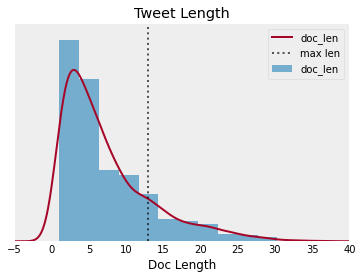

In [6]:
label_names = ['positive', 'neutral','negative']

train['doc_len'] = train['text'].apply(lambda words: len(words.split(' ')))

max_seq_len = np.round(train['doc_len'].mean() + train['doc_len'].std()).astype(int)

fig, ax = plt.subplots(figsize=(6,4))

train['doc_len'].plot(kind='hist',
                      density=True,
                      alpha=0.65,
                      bins=15)

train['doc_len'].plot(kind='kde')

ax.set_xlim(-5, 40)
ax.set_xlabel("Doc Length")
ax.set_ylim(0, 0.13)
ax.set_yticks([])
ax.set_ylabel("")
ax.set_title("Tweet Length")
ax.grid(False)
ax.axvline(x=max_seq_len, alpha=0.65, color='k', linestyle=':', label='max len')
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)

plt.legend()
plt.show()



---



### **[Part 6] Tokenizing Training Data**

In [7]:
raw_docs_train = train['text'].tolist()

MAX_NB_WORDS = 100000
num_classes = len(label_names)

print('=============================')
print(' >> Tokenizing Input Data >> ')
print('=============================')

tokenizer = Tokenizer(num_words=MAX_NB_WORDS,
                      lower=True,
                      char_level=False)
tokenizer.fit_on_texts(raw_docs_train)


word_seq_train = tokenizer.texts_to_sequences(raw_docs_train)

word_index = tokenizer.word_index

print('Dictionary Size: ', len(word_index))

word_seq_train = sequence.pad_sequences(word_seq_train, maxlen = max_seq_len)

 >> Tokenizing Input Data >> 
Dictionary Size:  6560




---



### **[Part 7] Hyperparameters**

In [0]:
batch_size = 256
num_epochs = 16

num_filters = 64
embed_dim   = 100
weight_decay = 1e-4



---



### **[Part 8] Embedding Matrix**

In [9]:
print('==================================')
print(' >> Preparing Embedding Matrix >> ')
print('==================================')

words_not_found = []

nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((nb_words+1, embed_dim))

for word, i in word_index.items():
  if i >= nb_words:
    continue
  embedding_vector = embeddings_index.get(word)
  if (embedding_vector is not None) and len(embedding_vector) > 0:
    embedding_matrix[i] = embedding_vector
  else:
    words_not_found.append(word)

 >> Preparing Embedding Matrix >> 




---



### **[Part 9] Convert into Categorical Data**

In [0]:
target = []

for i in train['label']:
  if i == -1:
    target.append(0)
  elif i == 0:
    target.append(1)
  elif i == 1:
    target.append(2)

train['new_label'] = target

In [0]:
from keras.utils import to_categorical

train_labels = to_categorical(train['new_label'])


---



### **[Part 10] Early Stopping for Avoid Overfitting Model**

In [0]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.01,
                               patience=3,
                               verbose=1)

callbacks_list = [early_stopping]


---



### **[Part 11] Conv. Neural Network Training**

In [13]:
print('=============================')
print('    >>> Training CNN >>>     ')
print('=============================')

model = Sequential()
model.add(Embedding(nb_words+1, embed_dim,
                    weights=[embedding_matrix],
                    input_length=max_seq_len,
                    trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(BatchNormalization())
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(num_classes, activation='softmax'))

adam = optimizers.Adam(lr = 0.01,
                      beta_1 = 0.9,
                      beta_2 = 0.999,
                      epsilon=1e-08,
                      decay=0.0)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

    >>> Training CNN >>>     
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 13, 100)           656100    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 13, 64)            44864     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 64)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 64)             256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6, 64)             28736     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
batch_normalization_2 (B

In [14]:
hist = model.fit(word_seq_train,
                 train_labels,
                 batch_size = batch_size,
                 epochs = num_epochs,
                 validation_split=0.2,
                 callbacks = callbacks_list,
                 shuffle=True,
                 verbose=2)

Train on 2320 samples, validate on 580 samples
Epoch 1/16
 - 1s - loss: 0.9848 - accuracy: 0.6172 - val_loss: 0.5933 - val_accuracy: 0.8224
Epoch 2/16
 - 0s - loss: 0.3592 - accuracy: 0.8810 - val_loss: 0.3983 - val_accuracy: 0.8879
Epoch 3/16
 - 0s - loss: 0.2430 - accuracy: 0.9237 - val_loss: 0.3417 - val_accuracy: 0.8897
Epoch 4/16
 - 0s - loss: 0.2028 - accuracy: 0.9384 - val_loss: 0.2551 - val_accuracy: 0.9328
Epoch 5/16
 - 0s - loss: 0.1560 - accuracy: 0.9504 - val_loss: 0.2097 - val_accuracy: 0.9431
Epoch 6/16
 - 0s - loss: 0.1220 - accuracy: 0.9634 - val_loss: 0.1842 - val_accuracy: 0.9466
Epoch 7/16
 - 0s - loss: 0.1073 - accuracy: 0.9681 - val_loss: 0.1816 - val_accuracy: 0.9431
Epoch 8/16
 - 0s - loss: 0.0949 - accuracy: 0.9741 - val_loss: 0.1725 - val_accuracy: 0.9448
Epoch 9/16
 - 0s - loss: 0.0807 - accuracy: 0.9759 - val_loss: 0.1727 - val_accuracy: 0.9397
Epoch 10/16
 - 0s - loss: 0.0880 - accuracy: 0.9797 - val_loss: 0.1685 - val_accuracy: 0.9362
Epoch 11/16
 - 0s - lo


---



### **[Part 12] Loss and Accuracy Visualization**

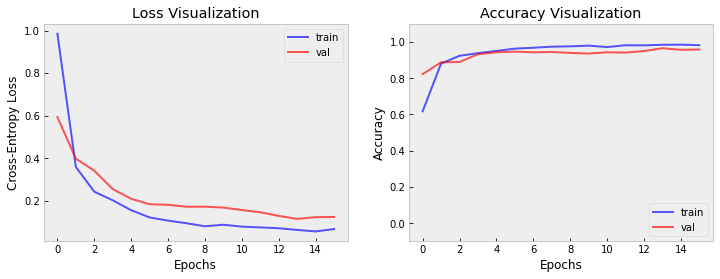

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(hist.history['loss'], lw=2.0, color='b', alpha=0.65, label='train')
ax1.plot(hist.history['val_loss'], lw=2.0, color='r', alpha=0.65, label='val')
ax1.set_title('Loss Visualization')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Cross-Entropy Loss')
ax1.legend(loc='upper right')
ax2.plot(hist.history['accuracy'], lw=2.0, color='b', alpha=0.65, label='train')
ax2.plot(hist.history['val_accuracy'], lw=2.0, color='r', alpha=0.65, label='val')
ax2.set_title('Accuracy Visualization')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')

ax1.grid(False)
ax2.grid(False)

ax2.set_ylim(-0.1, 1.1)
plt.show()



---



### **[Part 13] Save Model**

In [16]:
model.save("model.h5")
print("Saved model to disk")

Saved model to disk


In [17]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Saved tokenizer model to disk")

Saved tokenizer model to disk


In [0]:
!cp model.h5 '/content/drive/My Drive/Tugas_Akhir/model/'
!cp tokenizer.pickle '/content/drive/My Drive/Tugas_Akhir/model/'


---

